# ST456 2025 - Group 'I learn deep' project
# Ensemble model for RUL Prediction on Nasa's C-MAPSS datasets

In this notebook we attempt to create an Ensemble model as a combination of three different Hybrid Autoencoder architectures with the aim to improve model performance:

**Step 1: 5-Fold Cross-Validation per Model**

For each architecture (Autoencoder-BiLSTM, Autoencoder-ResCNN, Autoencoder-HDNN), perform 5-fold cross-validation on the training data. This results in 5 models per architecture, each trained on different splits of the same dataset.

**Step 2: Architecture-Specific Ensemble**

For each architecture, we average the predictions of the 5 CV models on the test set. This gives a single ensemble prediction per architecture (one for BiLSTM, one for ResCNN, one for HDNN).

**Step 3: Final Ensemble Across Architectures**

Combine the three architecture-level predictions using a weighted average. For example:
final_prediction = w1 * bilstm_pred + w2 * rescnn_pred + w3 * hdnn_pred
Weights w1, w2, w3 should sum to 1 and can be tuned manually or based on validation performance.

#### Import libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses, regularizers, Model, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Reshape, Concatenate, TimeDistributed, Bidirectional, Dropout, Flatten, BatchNormalization, LayerNormalization, Add, Activation
from tensorflow.keras.metrics import RootMeanSquaredError
import os
import pickle
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
from numpy import array, float32

# Mount Google Drive
from google.colab import drive
# Set working directory in google drive to import datasets
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Specify (hyper-)parameters

In [2]:
# Set autoencoder input parameters
latent_dim = 32
time_steps = 30

# Define weights for RUL vs reconstruction loss
alpha = 1.0
beta = 0.2

# Training parameters
n_epochs = 100
batch_size = 128
BATCH_SIZE = 512
es_patience = 15
lr_patience = 5
min_lr = 0.00001
factor = 0.5
NUM_FOLDS = 5

# Global parameters
WINDOW_SIZE = 30
R_EARLY = 125

#### Define functions to build the different model architectures

In [ ]:
# ------------------------------
# First building block: Autoencoder architecture
# ------------------------------

def build_autoencoder(X_train, latent_dim, time_steps):
    # Input: full sequence
    inputs = Input(shape=(time_steps, X_train.shape[2]))

    # --- ENCODER (Temporal Feature Extraction using Conv1D) ---
    x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv1D(filters=latent_dim, kernel_size=3, padding='same', activation='relu')(x)
    encoded = layers.BatchNormalization()(x)

    # --- DECODER (for reconstruction loss) ---
    x_rec = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(encoded)
    x_rec = layers.BatchNormalization()(x_rec)
    x_rec = layers.Dropout(0.3)(x_rec)
    x_rec = layers.Conv1D(filters=X_train.shape[2], kernel_size=5, padding='same', activation='sigmoid')(x_rec)
    x_rec = layers.BatchNormalization(name='reconstruction')(x_rec)
    return inputs, encoded, x_rec

# ------------------------------
# First Hybrid Head: Bi-LSTM
# ------------------------------

def build_bilstm(inputs, encoded, x_rec):
    # --- SEQUENCE MODELING (BiLSTM on encoded representation) ---
    x_seq = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(encoded)
    x_seq = layers.Dropout(0.2)(x_seq)
    x_seq = layers.Bidirectional(layers.LSTM(64))(x_seq)
    x_seq = layers.Dropout(0.2)(x_seq)

    # --- OUTPUT (RUL prediction) ---
    rul_pred = layers.Dense(1, activation='linear', name='rul')(x_seq)

    # --- Final model ---
    bilstm_model = Model(inputs=inputs, outputs=[rul_pred, x_rec])
    return bilstm_model

# ------------------------------
# Second Hybrid Head: HDNN
# ------------------------------

def build_hdnn(inputs, encoded, x_rec):
    # --- CNN Path (Simplified) ---
    reshaped = Reshape((encoded.shape[1], encoded.shape[2], 1))(encoded)
    x_cnn = Conv2D(32, kernel_size=(3, 1), padding='same', kernel_regularizer=regularizers.l2(0.005))(reshaped)
    x_cnn = BatchNormalization()(x_cnn)
    x_cnn = Activation('tanh')(x_cnn)

    x_cnn = Conv2D(48, kernel_size=(5, 1), padding='same', kernel_regularizer=regularizers.l2(0.005))(x_cnn)
    x_cnn = BatchNormalization()(x_cnn)
    x_cnn = Activation('tanh')(x_cnn)

    x_cnn = MaxPooling2D(pool_size=(2, 1))(x_cnn)
    x_cnn = Flatten()(x_cnn)
    x_cnn = Dropout(0.3)(x_cnn)

    # --- BiLSTM Path (Same, but lighter dropout) ---
    x_lstm = Bidirectional(LSTM(64, return_sequences=True,kernel_regularizer=regularizers.l2(0.005)))(inputs)
    x_lstm = Bidirectional(LSTM(64,kernel_regularizer=regularizers.l2(0.005)))(x_lstm)
    x_lstm = Dropout(0.3)(x_lstm)

    # --- Fusion ---
    merged = Concatenate()([x_cnn, x_lstm])
    x = Dense(64, activation='tanh',kernel_regularizer=regularizers.l2(0.001))(merged)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='tanh',kernel_regularizer=regularizers.l2(0.001))(x)

    rul_pred = Dense(1, activation='relu', name='rul')(x)

    hdnn_model = Model(inputs=inputs, outputs=[rul_pred, x_rec])
    return hdnn_model

# ------------------------------
# Third Hybrid Head: ResCNN
# ------------------------------

# Define optimal number of RBBs for each dataset
OPTIMAL_RBB = {
    'FD001': 6,
    'FD002': 3,
    'FD003': 4,
    'FD004': 2
}

LEARNING_PARAMS = {
    'FD001': {'learning_rate': 0.001, 'decay': 0.995},
    'FD002': {'learning_rate': 0.001, 'decay': 0.99},
    'FD003': {'learning_rate': 0.0005, 'decay': 0.995},
    'FD004': {'learning_rate': 0.001, 'decay': 0.995}
}

# Function to build a Residual Building Block (RBB-2 from the paper)
def residual_block(x, filters, kernel_size, block_id):
    """
    Implements the RBB-2 type Residual Block from the paper
    """
    # Shortcut path (with conv)
    shortcut = Conv1D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        name=f'shortcut_conv_{block_id}'
    )(x)
    shortcut = BatchNormalization(name=f'shortcut_bn_{block_id}')(shortcut)

    # Main path
    conv1 = Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        strides=1,
        padding='same',
        name=f'conv1_{block_id}'
    )(x)
    conv1 = BatchNormalization(name=f'bn1_{block_id}')(conv1)
    conv1 = Activation('tanh', name=f'tanh1_{block_id}')(conv1)

    conv2 = Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        strides=1,
        padding='same',
        name=f'conv2_{block_id}'
    )(conv1)
    conv2 = BatchNormalization(name=f'bn2_{block_id}')(conv2)
    conv2 = Activation('tanh', name=f'tanh2_{block_id}')(conv2)

    conv3 = Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        strides=1,
        padding='same',
        name=f'conv3_{block_id}'
    )(conv2)
    conv3 = BatchNormalization(name=f'bn3_{block_id}')(conv3)

    # Add shortcut to main path
    out = Add(name=f'add_{block_id}')([conv3, shortcut])
    out = Activation('tanh', name=f'out_tanh_{block_id}')(out)

    return out

# Function to build the ResCNN model
def build_rescnn(inputs, encoded, x_rec, num_rbb=6, learning_rate=0.001, decay=0.995):
    # First Conv layer
    x = Conv1D(
        filters=5,
        kernel_size=7,
        strides=1,
        padding='same',
        name='first_conv'
    )(encoded)
    x = Activation('tanh', name='first_tanh')(x)

    # Add Residual Building Blocks
    for i in range(num_rbb):
        x = residual_block(x, filters=3, kernel_size=5, block_id=i)

    # Flatten and FC layers
    x = Flatten(name='flatten')(x)
    x = Dropout(0.3, name='dropout1')(x)
    x = Dense(100, activation='tanh', name='fc1')(x)
    x = Dropout(0.3, name='dropout2')(x)

    # Output layer
    rul_pred = Dense(1, name='rul')(x)

    # Model and output
    rescnn_model = Model(inputs=inputs, outputs=[rul_pred, x_rec])
    rescnn_model.compile(
        optimizer=Adam(learning_rate=learning_rate, decay=decay),
        loss=['mse', 'mse'],
        loss_weights=[alpha, beta],
        metrics=[RootMeanSquaredError(name='rmse'), None]
    )
    return rescnn_model

# ------------------------------
# Evaluation functions
# ------------------------------

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

def asymmetric_mse(y_true, y_pred):
    error = y_pred - y_true
    under = tf.square(error) * tf.cast(error < 0, tf.float32)
    over = tf.square(error) * tf.cast(error >= 0, tf.float32) * 2
    return tf.reduce_mean(under + over)

def phm_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        if pred > true:
            score = np.exp(np.abs(pred - true) / 13) - 1
        else:
            score = np.exp(np.abs(pred - true) / 10) - 1
        scores.append(score)
    return np.sum(scores)

# ------------------------------
# Train models using 5-fold CV and create CV-based ensemble for each architecture
# ------------------------------

def ensemble_predict(models, X):
    all_preds = []
    for model in models:
        preds = model.predict(X)
        y_pred = preds[0] if isinstance(preds, (list, tuple)) else preds
        y_pred = np.asarray(y_pred).flatten()
        all_preds.append(y_pred)

    # Stack and average
    all_preds = np.stack(all_preds, axis=0)
    avg_preds = np.mean(all_preds, axis=0)
    return avg_preds

def train_rescnn_ensemble_model(X_train, latent_dim, time_steps, y_train, X_val, y_val, name):
    """
    Train an ensemble model for a specific dataset
    """
    num_rbb = OPTIMAL_RBB[name]
    lr_params = LEARNING_PARAMS[name]

    print(f"\nTraining ensemble for {name} with {num_rbb} RBBs...")

    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    rescnn_fold_models = []

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    ]

    fold = 1
    for train_idx, val_idx in kf.split(X_train):
        print(f"Training fold {fold}/{NUM_FOLDS}")
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Build and train model
        inputs, encoded, x_rec = build_autoencoder(X_train=X_train, latent_dim=latent_dim, time_steps=time_steps)
        model = build_rescnn(
            inputs=inputs,
            encoded=encoded,
            x_rec=x_rec,
            num_rbb=num_rbb,
            learning_rate=lr_params['learning_rate'],
            decay=lr_params['decay']
        )

        history = model.fit(
            X_fold_train, [y_fold_train, X_fold_train],
            validation_data=(X_fold_val, [y_fold_val, X_fold_val]),
            epochs=n_epochs,
            batch_size=BATCH_SIZE,
            callbacks=callbacks,
            verbose=0
        )

        # Print fold results
        val_loss = history.history['val_loss'][-1]
        val_rmse = history.history['val_rul_rmse'][-1]
        print(f"Fold {fold} results: val_loss={val_loss:.4f}, val_rmse={val_rmse:.4f}")

        # Save model
        rescnn_fold_models.append(model)
        fold += 1

    # Evaluate ensemble on validation set
    val_preds = ensemble_predict(rescnn_fold_models, X_val)
    val_rmse = np.sqrt(np.mean((val_preds.flatten() - y_val) ** 2))
    val_score = phm_score(y_val, val_preds.flatten())

    print(f"\n{name} Fold-averaged validation results:")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"Score: {val_score:.4f}")

    return rescnn_fold_models

def train_bilstm_ensemble_model(X_train, latent_dim, time_steps, y_train, X_val, y_val, name):
    """
    Train an ensemble model for a specific dataset
    """
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    bilstm_fold_models = []

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=es_patience, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=lr_patience, min_lr=min_lr)
    ]

    fold = 1
    for train_idx, val_idx in kf.split(X_train):
        print(f"Training fold {fold}/{NUM_FOLDS}")
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Build and train model
        inputs, encoded, x_rec = build_autoencoder(X_train=X_train, latent_dim=latent_dim, time_steps=time_steps)
        model = build_bilstm(
            inputs=inputs,
            encoded=encoded,
            x_rec=x_rec,
        )

        model.compile(
            optimizer='adam',
            loss=['mse', 'mse'],
            loss_weights=[alpha, beta],
            metrics=[RootMeanSquaredError(name='rmse'), None]
        )

        history = model.fit(
            X_fold_train, [y_fold_train, X_fold_train],
            validation_data=(X_fold_val, [y_fold_val, X_fold_val]),
            epochs=n_epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        # Print fold results
        val_loss = history.history['val_loss'][-1]
        val_rmse = history.history['val_rul_rmse'][-1]
        print(f"Fold {fold} results: val_loss={val_loss:.4f}, val_rmse={val_rmse:.4f}")

        # Save model
        bilstm_fold_models.append(model)
        fold += 1

    # Evaluate ensemble on validation set
    val_preds = ensemble_predict(bilstm_fold_models, X_val)
    val_rmse = np.sqrt(np.mean((val_preds.flatten() - y_val) ** 2))
    val_score = phm_score(y_val, val_preds.flatten())

    print(f"\n{name} Fold-averaged validation results:")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"Score: {val_score:.4f}")

    return bilstm_fold_models

def train_hdnn_ensemble_model(X_train, latent_dim, time_steps, y_train, X_val, y_val, name):
    """
    Train an ensemble model for a specific dataset
    """
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    hdnn_fold_models = []

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=es_patience, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=lr_patience, min_lr=min_lr)
    ]

    fold = 1
    for train_idx, val_idx in kf.split(X_train):
        print(f"Training fold {fold}/{NUM_FOLDS}")
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Build and train model
        inputs, encoded, x_rec = build_autoencoder(X_train=X_train, latent_dim=latent_dim, time_steps=time_steps)
        model = build_hdnn(
            inputs=inputs,
            encoded=encoded,
            x_rec=x_rec,
        )

        model.compile(
            optimizer='adam',
            loss=['mse', 'mse'],
            loss_weights=[alpha, beta],
            metrics=[RootMeanSquaredError(name='rmse'), None]
        )

        history = model.fit(
            X_fold_train, [y_fold_train, X_fold_train],
            validation_data=(X_fold_val, [y_fold_val, X_fold_val]),
            epochs=n_epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        # Print fold results
        val_loss = history.history['val_loss'][-1]
        val_rmse = history.history['val_rul_rmse'][-1]
        print(f"Fold {fold} results: val_loss={val_loss:.4f}, val_rmse={val_rmse:.4f}")

        # Save model
        hdnn_fold_models.append(model)
        fold += 1

    # Evaluate ensemble on validation set
    val_preds = ensemble_predict(hdnn_fold_models, X_val)
    val_rmse = np.sqrt(np.mean((val_preds.flatten() - y_val) ** 2))
    val_score = phm_score(y_val, val_preds.flatten())

    print(f"\n{name} Validation Results:")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"Score: {val_score:.4f}")

    return hdnn_fold_models

def evaluate_test_set(models, X_test, y_test, dataset_name):
    """
    Evaluate trained internal ensemble on test set
    """
    # Generate predictions
    test_preds = ensemble_predict(models, X_test)

    # Calculate metrics
    test_rmse = np.sqrt(np.mean((test_preds.flatten() - y_test) ** 2))
    test_score = phm_score(y_test, test_preds.flatten())

    print(f"\n{dataset_name} Test Results:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"Score: {test_score:.4f}")

    return test_rmse, test_score, test_preds

# ------------------------------
# Final Plots
# ------------------------------

# Plot dispersion plot
def evaluate_model(prediction_results, dataset_names):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.tight_layout(pad=5.0)

    scores = {}

    for i, name in enumerate(dataset_names):
        y_test = prediction_results[name]['actual']
        y_pred = prediction_results[name]['final_preds']

        # Evaluate
        rmse_score = rmse(y_test, y_pred)
        phm = phm_score(y_test, y_pred)
        scores[name] = {'rmse': rmse_score, 'phm': phm}

        # Plot
        ax = axes[i // 2, i % 2]
        ax.scatter(y_test, y_pred, alpha=0.6)
        mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
        ax.plot([mn, mx], [mn, mx], 'r--')
        ax.set_title(f"{name}\nRMSE: {rmse_score:.2f}, PHM: {phm:.2f}")
        ax.set_xlabel('Actual RUL')
        ax.set_ylabel('Predicted RUL')
        ax.grid(True)

    plt.savefig(f'{save_dir}/All_Plots_Actual_vs_Predicted_RUL.png')
    plt.show()

    return scores

def load_normalized_data(file_path):
    with open(f"{file_path}/normalized_data.pkl", 'rb') as f:
        normalized_data = pickle.load(f)
    return normalized_data

# Plot the predicted vs. actual RUL for a subset of engines
def plot_engine_predictions_ensemble(
    bilstm_models, hdnn_models, rescnn_models,
    bilstm_rmse, hdnn_rmse, rescnn_rmse,
    normalized_data, dataset_id='FD001',
    engine_ids=None, num_engines=4, sequence_length=30
):
    # Compute ensemble weights
    w1 = 1 / bilstm_rmse
    w2 = 1 / hdnn_rmse
    w3 = 1 / rescnn_rmse
    total_weight = w1 + w2 + w3
    w1, w2, w3 = w1 / total_weight, w2 / total_weight, w3 / total_weight

    # Load test data
    test_df = normalized_data[f'{dataset_id}_test_rul_norm']

    # Identify sensor columns
    non_features = ['engine', 'time', 'RUL', 'RUL_pw', 'cluster', 'oc_1', 'oc_2', 'oc_3']
    sensor_columns = [col for col in test_df.columns if col not in non_features]

    # Select engines
    if engine_ids is None:
        engine_ids = np.random.choice(test_df['engine'].unique(),
                                      size=min(num_engines, len(test_df['engine'].unique())),
                                      replace=False)

    # Prepare plot grid
    cols = 2
    rows = int(np.ceil(len(engine_ids) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = axes.flatten() if rows > 1 or cols > 1 else [axes]

    for i, engine_id in enumerate(engine_ids):
        if i >= len(axes):
            break

        engine_data = test_df[test_df['engine'] == engine_id]
        actual_rul = engine_data['RUL_pw'].values
        cycles = engine_data['time'].values

        predictions = []

        for j in range(len(engine_data) - sequence_length + 1):
            window = engine_data[sensor_columns].values[j:j + sequence_length]
            window = np.array([window])

            # Predict with all models
            bilstm_preds = np.array([model.predict(window, verbose=0)[0][0] for model in bilstm_models])
            hdnn_preds = np.array([model.predict(window, verbose=0)[0][0] for model in hdnn_models])
            rescnn_preds = np.array([model.predict(window, verbose=0)[0][0] for model in rescnn_models])

            # Average per architecture
            bilstm_avg = np.mean(bilstm_preds)
            hdnn_avg = np.mean(hdnn_preds)
            rescnn_avg = np.mean(rescnn_preds)

            # Weighted ensemble prediction
            final_pred = w1 * bilstm_avg + w2 * hdnn_avg + w3 * rescnn_avg
            predictions.append(final_pred)

        # Plot
        ax = axes[i]
        ax.plot(cycles[sequence_length-1:], actual_rul[sequence_length-1:], 'b-', label='Actual RUL')
        ax.plot(cycles[sequence_length-1:], predictions, 'r--', label='Predicted RUL (Ensemble)')
        ax.set_title(f'Engine {engine_id} - {dataset_id}')
        ax.set_ylabel('RUL')
        ax.set_xlabel('Cycle')
        ax.legend()
        ax.grid(True)

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# ------------------------------
# Load saved models from the directory
# ------------------------------

# Function to load the saved models from the directory
def load_ensemble_models(save_dir, name, model_type, num_folds=5):
    models = []
    for fold in range(1, num_folds + 1):
        model_path = os.path.join(save_dir, f"{name}_{model_type}_fold{fold}.h5")
        model = load_model(model_path, compile=False)
        models.append(model)
    return models

#### Pipeline and Execution

In [ ]:
# Save Dataset names in list
dataset_names = ["FD001", "FD002", "FD003", "FD004"]

# Set base path
base_path = '/content/drive/MyDrive/Colab Notebooks/tensors'

# Paths to directories for loading data and saving plots
file_path = '/content/drive/MyDrive/Colab Notebooks/tensors'
save_dir = '/content/drive/MyDrive/Colab Notebooks/dl_project/ensemble'

def pipeline(dataset_names, base_path):
    results = {}
    for name in dataset_names:
        # Load preprocessed data
        X = np.load(f'{base_path}/{name}_X_augmented.npy')
        y = np.load(f'{base_path}/{name}_y_augmented.npy')
        test_data = np.load(f'{base_path}/{name}_test_windows.npz')
        X_test = test_data['X_test']
        y_test = test_data['y_test']

        # Split train/val
        X_train, X_val, y_train, y_val = train_test_split(
            X, y,
            test_size=0.2,
            random_state=42,
            stratify=np.floor(y / 10).astype(int)
        )

        print(f"[{name}] Train shape: {X_train.shape}, Val shape: {X_val.shape}")
        y_train[y_train >= 130] = 130

        # BILSTM
        bilstm_models = train_bilstm_ensemble_model(X_train, latent_dim, time_steps, y_train, X_val, y_val, name)
        for i, model in enumerate(bilstm_models):
            model.save(f"{save_dir}/{name}_bilstm_fold{i+1}.h5")
        bilstm_rmse, bilstm_score, bilstm_preds = evaluate_test_set(bilstm_models, X_test, y_test, name)

        # HDNN
        hdnn_models = train_hdnn_ensemble_model(X_train, latent_dim, time_steps, y_train, X_val, y_val, name)
        for i, model in enumerate(hdnn_models):
            model.save(f"{save_dir}/{name}_hdnn_fold{i+1}.h5")
        hdnn_rmse, hdnn_score, hdnn_preds = evaluate_test_set(hdnn_models, X_test, y_test, name)

        # ResCNN
        rescnn_models = train_rescnn_ensemble_model(X_train, latent_dim, time_steps, y_train, X_val, y_val, name)
        for i, model in enumerate(rescnn_models):
            model.save(f"{save_dir}/{name}_rescnn_fold{i+1}.h5")
        rescnn_rmse, rescnn_score, rescnn_preds = evaluate_test_set(rescnn_models, X_test, y_test, name)

        # Final Ensemble (Inverse RMSE weighting)
        w1 = 1 / bilstm_rmse
        w2 = 1 / hdnn_rmse
        w3 = 1 / rescnn_rmse
        total = w1 + w2 + w3
        w1, w2, w3 = w1 / total, w2 / total, w3 / total

        final_pred = w1 * bilstm_preds + w2 * hdnn_preds + w3 * rescnn_preds
        final_rmse = np.sqrt(np.mean((final_pred - y_test) ** 2))
        final_score = phm_score(y_test, final_pred)

        print(f"\n{name} Final Ensemble Test Results:")
        print(f"Ensemble RMSE: {final_rmse:.4f}")
        print(f"Ensemble Score: {final_score:.4f}")

        # Store results
        results[name] = {
            'bilstm_rmse': bilstm_rmse,
            'hdnn_rmse': hdnn_rmse,
            'rescnn_rmse': rescnn_rmse,
            'bilstm_score': bilstm_score,
            'hdnn_score': hdnn_score,
            'rescnn_score': rescnn_score,
            'bilstm_preds': bilstm_preds,
            'hdnn_preds': hdnn_preds,
            'rescnn_preds': rescnn_preds,
            'final_preds': final_pred,
            'final_rmse': final_rmse,
            'final_score': final_score,
            'actual': y_test
        }

    # Create summary
    summary_df = pd.DataFrame({
        'Dataset': results.keys(),
        'BiLSTM_RMSE': [results[k]['bilstm_rmse'] for k in results],
        'HDNN_RMSE': [results[k]['hdnn_rmse'] for k in results],
        'ResCNN_RMSE': [results[k]['rescnn_rmse'] for k in results],
        'Final_Ensemble_RMSE': [results[k]['final_rmse'] for k in results],
        'Final_Ensemble_Score': [results[k]['final_score'] for k in results]
    })

    summary_df.to_csv(f'{save_dir}/summary.csv', index=False)

    print("\nSummary of Test Results:")
    print(summary_df)
    return results

In [ ]:
pipeline(dataset_names=dataset_names, base_path=base_path)

Output hidden; open in https://colab.research.google.com to view.

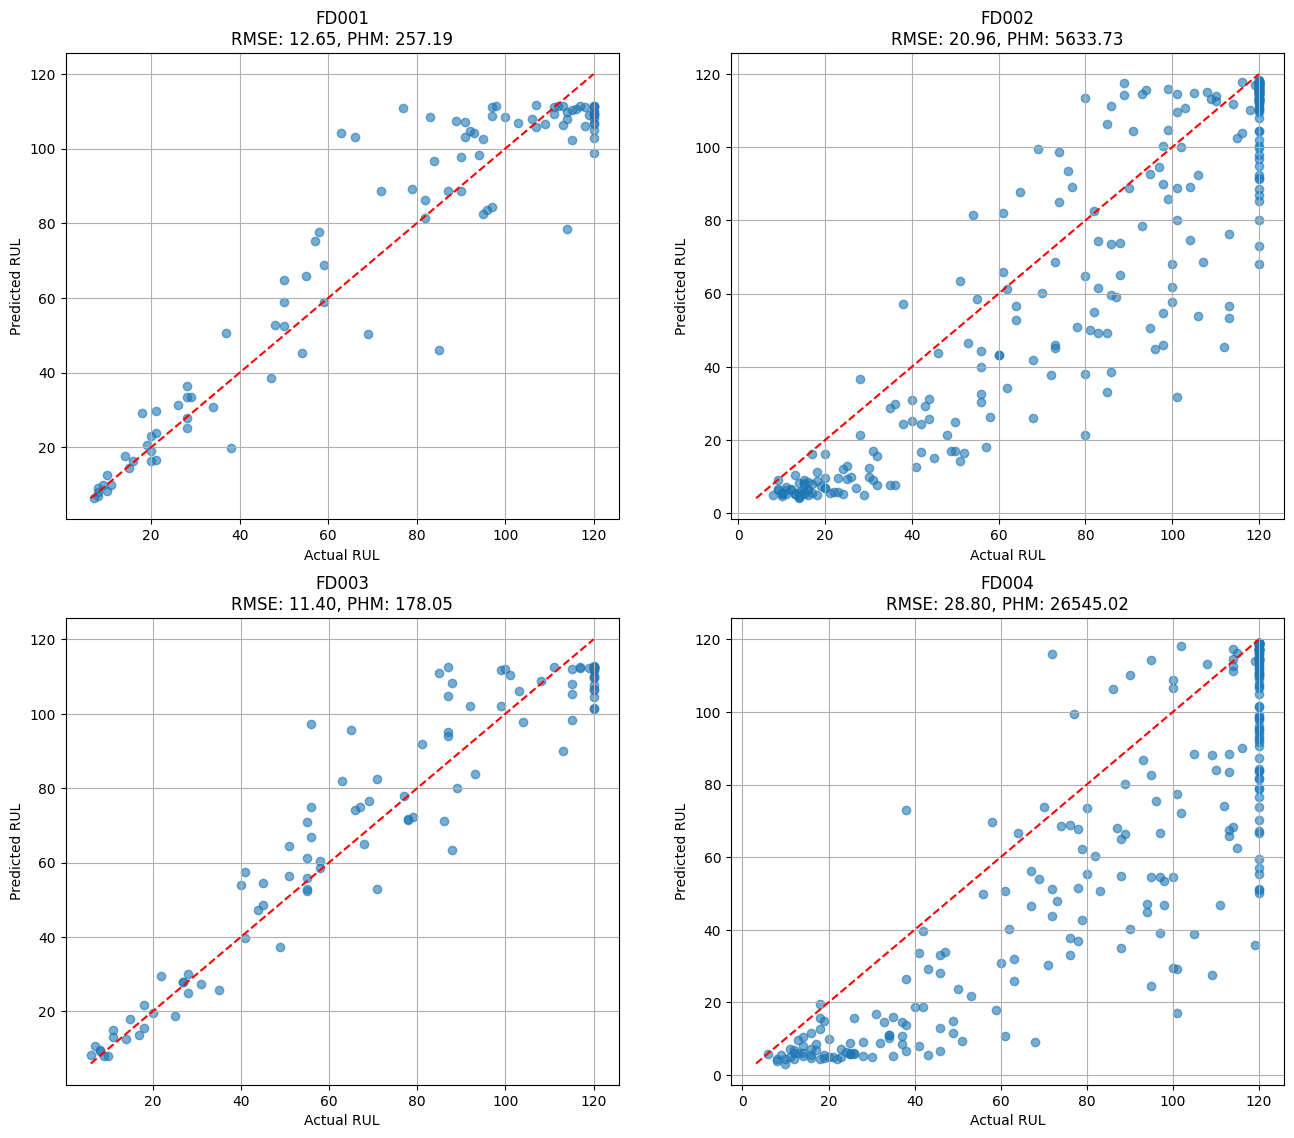

{'FD001': {'rmse': np.float32(12.649883), 'phm': np.float32(257.19403)},
 'FD002': {'rmse': np.float32(20.957066), 'phm': np.float32(5633.733)},
 'FD003': {'rmse': np.float32(11.3952675), 'phm': np.float32(178.05234)},
 'FD004': {'rmse': np.float32(28.79928), 'phm': np.float32(26545.021)}}

In [ ]:
# Plot the actual vs. predicted RUL of the final ensemble model for all four datasets
evaluate_model(prediction_results=results, dataset_names=dataset_names)

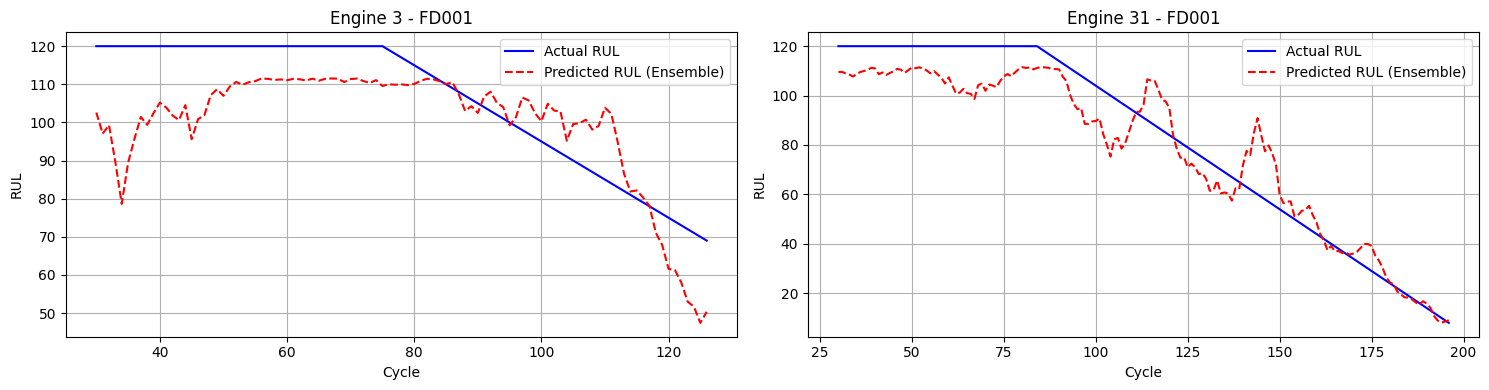

In [11]:
# Plot the actual vs. predicted RUL for a subset of engines for the FD001 dataset
name = "FD001"

# Load models from directory
bilstm_models = load_ensemble_models(save_dir, name, "bilstm")
hdnn_models = load_ensemble_models(save_dir, name, "hdnn")
rescnn_models = load_ensemble_models(save_dir, name, "rescnn")

# Load the normalized data
normalized_data = load_normalized_data(file_path)

# Load RMSEs from dictionary
bilstm_rmse = results['FD001']['bilstm_rmse']
hdnn_rmse = results['FD001']['hdnn_rmse']
rescnn_rmse = results['FD001']['rescnn_rmse']

# Plot predictions per engine
plot_engine_predictions_ensemble(bilstm_models, hdnn_models, rescnn_models,
    bilstm_rmse, hdnn_rmse, rescnn_rmse,
    normalized_data, dataset_id='FD001',
    engine_ids=None, num_engines=2, sequence_length=30
)